In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### TIME AVERAGE MSD

Aim to plot time average mean squared deviation against tau

CALLUM'S VERSION

/var/folders/g_/qk19_b9s62l1w5lmx5_1gmzjx_y855/T/ipykernel_3184/3373430725.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["x_body_lagged", "y_body_lagged"]] = df.groupby(["file", "track_id"])["x_body", "y_body"].shift(tau)
/var/folders/g_/qk19_b9s62l1w5lmx5_1gmzjx_y855/T/ipykernel_3184/3373430725.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["x_body_lagged", "y_body_lagged"]] = df.groupby(["file", "track_id"])["x_body", "y_body"].shift(tau)
/var/folders/g_/qk19_b9s62l1w5lmx5_1gmzjx_y855/T/ipykernel_3184/3373430725.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["x_body_lagged", "y_body_lagged"]] = df.groupby(["file", "track_id"])["x_body", "y_body"].shift(tau)
/var/folders/g_/qk19_b9s62l1w5lmx5_1gmzjx_y855/T/ipykernel

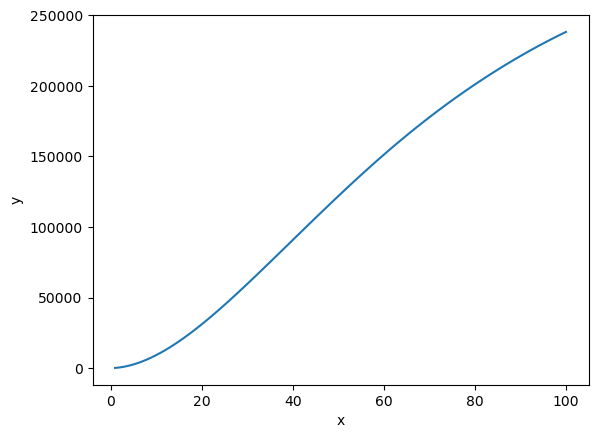

In [ ]:
def load_data(dir):
    dfs = []
    for file in os.listdir(dir):
        if file.endswith("csv"):
            path = os.path.join(dir, file)
            df   = pd.read_csv(path)
            df["file"] = file

            dfs.append(df)

    df = pd.concat(dfs)
    df = df[["file", "track_id", "frame", "x_body", "y_body"]]

    return df

def calculate_x2(df, tau):
    # a. append lagged data
    df = df.sort_values(by = ["file", "track_id", "frame"])
    df[["x_body_lagged", "y_body_lagged"]] = df.groupby(["file", "track_id"])["x_body", "y_body"].shift(tau)

    # b. calculate msd for each frames
    df["msd"] = (df["x_body"] - df["x_body_lagged"]) ** 2 + (df["y_body"] - df["y_body_lagged"]) ** 2

    # c. aggregate to avg by frame
    df = df[df["msd"].notnull()] 
    df = df.groupby(["frame"])["msd"].mean()

    # d. take avg of avg across frames
    x2 = df.sum() / len(df)
    return x2

def plot_x2s(dir, taus):
    df = load_data(dir)

    x2s = []
    for tau in taus:
        x2 = calculate_x2(df, tau)
        x2s.append(x2)

    sns.lineplot({"x":taus, "y":x2s}, x = "x", y = "y")

plot_x2s('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/N1/FOOD', list(range(1, 101, 1)))

### TIME AVERAGE MSD

-> concat all files 

-> calculate average msd for each frame 


-> THIS CALCULATES THE TIME AVERAGE MSD ONLY ACCOUNTING FOR TIME 0 AND TIME 0 + TAU FOR EACH UNIQUE FRAME; THUS, THIS IGNORES ALL TRACK DATA POST TIME 0+TAU

-> for each tau calculate the average of all the msd's


In [60]:
# JOIN ALL FILES 

def concat(directory):
    
    dfs = []

    for file in os.listdir(directory):
        # print(file)
            
        if file.endswith("csv"):

            file_path = os.path.join(directory, file) # join path and file
        
            df = pd.read_csv(file_path) # read the csv file

            df = df.dropna(subset=['x_body', 'y_body']) # drop rows without body parts 

            if df.empty:
                print(f"Warning: {file} has no valid data after dropping NaNs.")
                continue

            df["file"] = file # column with file name 

            dfs.append(df)

    df = pd.concat(dfs).reset_index()
    df = df[["file", "track_id", "frame", "x_body", "y_body"]] # chose specific parts of the dataframe

    # sort the df by a) file b) unique track c) frame each track present for 
    df = df.sort_values(by = ["file", "track_id", "frame"]) 

    return df 


# CALCULATE MEAN SQUARED DISPLACAMENT (Ttau - T0) FOR EACH TRACK 

# WANT TO RETURN ONE NUMBER PER TAU 

def msd_0_tau(df, tau): # simply imagine this is a single tau for now 

    # df sorted by file, track and frame
    # loop through every track 

    # count number of vIABLE tracks 
    viable_tracks = 0
    
    msd = []

    for track in df['track_id'].unique():
        # print(track)

        track_unique = df[df['track_id'] == track]

        if len(track_unique) <= tau:
            continue 

        viable_tracks += 1
        
        initial_x, initial_y = track_unique.iloc[0][['x_body', 'y_body']] # when sleap better originate from 0 for each track 
        # print(initial_x)

        tau_x, tau_y = track_unique.iloc[tau][['x_body', 'y_body']]
        # print(tau_x)

        mean_square_displacement = (tau_x - initial_x) ** 2 + (tau_y - initial_y) ** 2 

        msd.append(mean_square_displacement)
    
    return sum(msd) / viable_tracks


def time_average_msd_0_tau(directory, taus):

    df = concat(directory)

    msds = []

    for tau in taus:

        msd = msd_0_tau(df, tau)

        msds.append(msd)
    
    tau_msd_df = pd.DataFrame({'tau': taus, 'msd': msds})

    
    return tau_msd_df



In [61]:
# try with very short directory = works 
# put in print statments such that i do trust its working :)

agarose_n10 = time_average_msd_0_tau('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/agarose-2', list(range(1, 101, 1)))

agarose_n10

,tau,msd
0,1,114142.432918
1,2,168770.565420
2,3,172287.696170
3,4,182771.075472
4,5,201210.194250
...,...,...
95,96,364106.100846
96,97,365885.257406
97,98,362299.900865
98,99,363444.818094


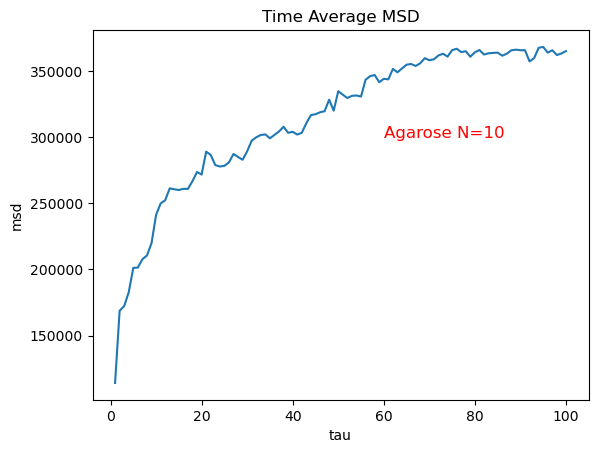

In [62]:
sns.lineplot(data=agarose_n10, x='tau', y='msd')

plt.title('Time Average MSD')

plt.text(60, 300000, 'Agarose N=10', fontsize=12, color='red')

plt.show()

In [ ]:
food_n10 = time_average_msd('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/food-2', list(range(1, 101, 1)))

food_n10

,tau,msd
0,1,33828.389985
1,2,34604.261289
2,3,33175.394121
3,4,56140.203414
4,5,57060.985637
...,...,...
95,96,274249.002379
96,97,266865.868653
97,98,267580.766765
98,99,265578.518214


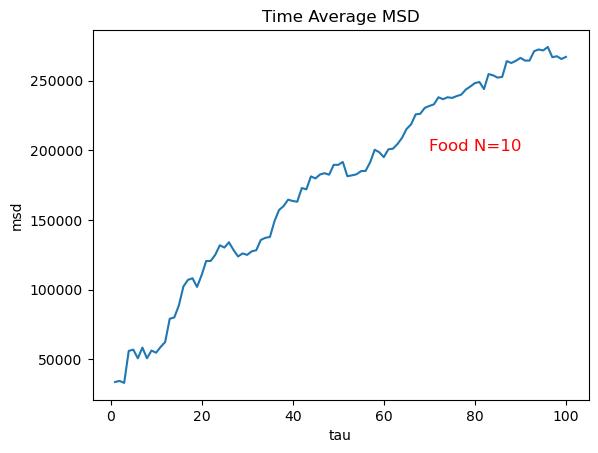

In [ ]:
sns.lineplot(data=food_n10, x='tau', y='msd')

plt.title('Time Average MSD')

plt.text(70, 200000, 'Food N=10', fontsize=12, color='red')

plt.show()

### TIME AVERAGE MSD

-> concat all files

-> calculate the mean squared displacement for each tau accounting for all track data e.g. 

T 0 -> T 0 + tau

T 1 -> T 1 + tau

T 2 -> T 2 + tau

-> for every single track and then average all of these displacements for that tau 



THIS VERSION WAS AN INITIAL VERSION AND SHOULD THEORETICALLY WORK HOWEVER IS EXTREMELY SLOW

In [9]:
# JOIN ALL FILES 

def concat(directory):
    
    dfs = []

    for file in os.listdir(directory):
        # print(file)
            
        if file.endswith("csv"):

            file_path = os.path.join(directory, file) # join path and file
        
            df = pd.read_csv(file_path) # read the csv file

            df = df.dropna(subset=['x_body', 'y_body']) # drop rows without body parts 

            if df.empty:
                print(f"Warning: {file} has no valid data after dropping NaNs.")
                continue

            df["file"] = file # column with file name 

            dfs.append(df)

    df = pd.concat(dfs).reset_index()
    df = df[["file", "track_id", "frame", "x_body", "y_body"]] # chose specific parts of the dataframe

    # sort the df by a) file b) unique track c) frame each track present for 
    df = df.sort_values(by = ["file", "track_id", "frame"]) 

    return df 


# CALCULATE MEAN SQUARED DISPLACAMENT (Ttau - T0) FOR EACH TRACK 

# WANT TO RETURN ONE NUMBER PER TAU 

# need it to be faster 

def msd_per_tau(df, tau): # simply imagine this is a single tau for now 

    # df sorted by file, track and frame
    # loop through every track 

    # count number of vIABLE tracks 
    viable_tracks = 0
    
    msd = []
    
    # count the number of viable tracks for the tau 
    for track in df['track_id'].unique():
        # print(track)

        track_unique = df[df['track_id'] == track]

        if len(track_unique) <= tau:
            continue 

        viable_tracks += 1

        for i in range(len(track_unique) - tau):
        # for i, row in track_unique.iterrows():
            
            initial_x, initial_y = track_unique.iloc[i][['x_body', 'y_body']]
            
            tau_x, tau_y = track_unique.iloc[i + tau][['x_body', 'y_body']]
            
            mean_square_displacement = (tau_x - initial_x) ** 2 + (tau_y - initial_y) ** 2 
            
            msd.append(mean_square_displacement)
    
    
    return sum(msd) / viable_tracks


def time_average_msd(directory, taus):

    df = concat(directory)

    msds = []

    for tau in taus:

        msd = msd_per_tau(df, tau)

        msds.append(msd)
    
    tau_msd_df = pd.DataFrame({'tau': taus, 'msd': msds})

    
    return tau_msd_df



REVISED VERSION WHICH IS FAST

In [63]:
# JOIN ALL FILES 

def concat(directory):
    
    dfs = []

    for file in os.listdir(directory):
        # print(file)
            
        if file.endswith("csv"):

            file_path = os.path.join(directory, file) # join path and file
        
            df = pd.read_csv(file_path) # read the csv file

            df = df.dropna(subset=['x_body', 'y_body']) # drop rows without body parts 

            if df.empty:
                print(f"Warning: {file} has no valid data after dropping NaNs.")
                continue

            df["file"] = file # column with file name 

            dfs.append(df)

    df = pd.concat(dfs).reset_index()
    df = df[["file", "track_id", "frame", "x_body", "y_body"]] # chose specific parts of the dataframe

    # sort the df by a) file b) unique track c) frame each track present for 
    df = df.sort_values(by = ["file", "track_id", "frame"]) 

    return df 


# CALCULATE MEAN SQUARED DISPLACAMENT (Ttau - T0) FOR EACH TRACK 

# WANT TO RETURN ONE NUMBER PER TAU 

# need it to be faster 

def msd_per_tau(df, tau): # simply imagine this is a single tau for now 

    
    grouped_data = df.groupby(['file', 'track_id'])

    displacements = []

    for (file, track_id), track_data in grouped_data:

        track_data = track_data.sort_values(by='frame').reset_index(drop=True)

        if len(track_data) > tau:

            initial_positions = track_data[['x_body', 'y_body']].values[:-tau]
            tau_positions = track_data[['x_body', 'y_body']].values[tau:]
            disp = np.sum((tau_positions - initial_positions) ** 2, axis=1)

            displacements.append(disp)


    if displacements:
        displacements = np.concatenate(displacements)

        return np.mean(displacements)
    else:
        return np.nan

    # np.concatenate(displacements)

    # return np.mean(displacements)


def time_average_msd(directory, taus):

    df = concat(directory)

    msds = []

    for tau in taus:

        msd = msd_per_tau(df, tau)

        msds.append(msd)
    
    tau_msd_df = pd.DataFrame({'tau': taus, 'msd': msds})

    
    return tau_msd_df


In [64]:
food_n10 = time_average_msd('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/food-2', list(range(1, 101, 1)))

food_n10

,tau,msd
0,1,1866.899594
1,2,2855.860925
2,3,3831.152715
3,4,4860.771409
4,5,5955.839107
...,...,...
95,96,183860.416139
96,97,185246.760598
97,98,186610.959753
98,99,187952.393651


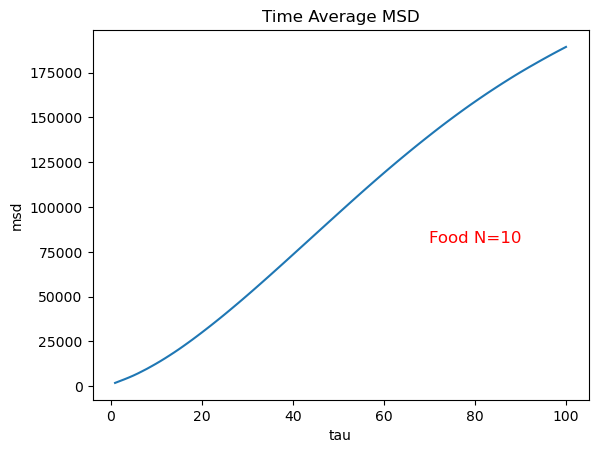

In [65]:
sns.lineplot(data=food_n10, x='tau', y='msd')

plt.title('Time Average MSD')

plt.text(70, 80000, 'Food N=10', fontsize=12, color='red')

plt.show()

In [53]:
agarose_n10 = time_average_msd('/Volumes/lab-windingm/home/users/cochral/AttractionRig/modelling-behaviour/extract/agarose-2', list(range(1, 101, 1)))

agarose_n10

,tau,msd
0,1,2150.914645
1,2,3423.609949
2,3,4651.989741
3,4,5936.427932
4,5,7331.193988
...,...,...
95,96,304544.487715
96,97,306685.812650
97,98,308779.104687
98,99,310824.567474


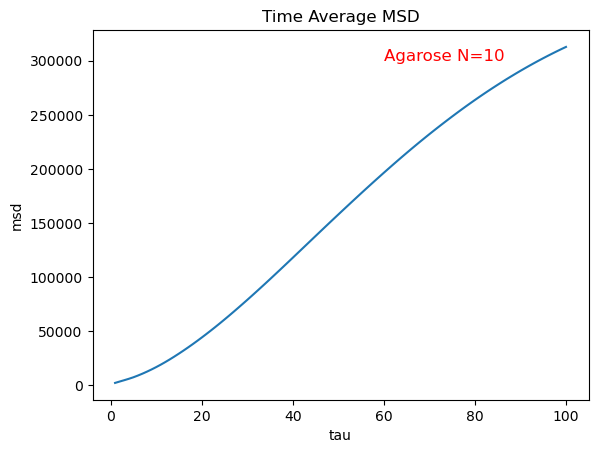

In [54]:
sns.lineplot(data=agarose_n10, x='tau', y='msd')


plt.title('Time Average MSD')

plt.text(60, 300000, 'Agarose N=10', fontsize=12, color='red')

plt.show()

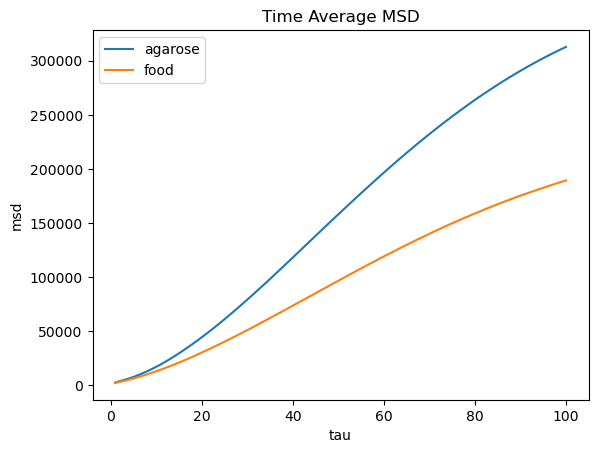

In [55]:
sns.lineplot(data=agarose_n10, x='tau', y='msd', label='agarose')
sns.lineplot(data=food_n10, x='tau', y='msd', label='food')


plt.title('Time Average MSD')

plt.show()